In [18]:
!pip -q install calplot

# Imports

In [19]:
import numpy as np 
import pandas as pd
import datetime as dt
import seaborn as sns
from colorama import Style, Fore
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, SplineTransformer, FunctionTransformer
from category_encoders import OneHotEncoder, TargetEncoder
from datetime import datetime
from lightgbm import LGBMRegressor
from scipy.optimize import differential_evolution, minimize
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline, Pipeline
import gc
from scipy.signal import periodogram
from scipy.stats import kurtosis
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.base import clone, BaseEstimator, TransformerMixin
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import PredictionErrorDisplay, mean_absolute_error
import os
from sklearn.kernel_approximation import Nystroem
import plotly_express as px
import calplot
from sklearn import set_config
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
set_config(transform_output='pandas')
plt.style.use('ggplot')

/kaggle/input/rohlik-sales-forecasting-challenge/calendar.csv
/kaggle/input/rohlik-sales-forecasting-challenge/test_weights.csv
/kaggle/input/rohlik-sales-forecasting-challenge/inventory.csv
/kaggle/input/rohlik-sales-forecasting-challenge/sales_train.csv
/kaggle/input/rohlik-sales-forecasting-challenge/sales_test.csv
/kaggle/input/rohlik-sales-forecasting-challenge/solution.csv
/kaggle/input/rohlik-sales-forecasting-challenge-v2/calendar.csv
/kaggle/input/rohlik-sales-forecasting-challenge-v2/test_weights.csv
/kaggle/input/rohlik-sales-forecasting-challenge-v2/inventory.csv
/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_train.csv
/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_test.csv
/kaggle/input/rohlik-sales-forecasting-challenge-v2/solution.csv


# Reading Data

* Load data and merge

In [20]:
sales_train = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_train.csv',parse_dates=['date'])
sales_test = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_test.csv',parse_dates=['date'])
inventory = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/inventory.csv')
calendar = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/calendar.csv',parse_dates=['date'])
test_weights = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/test_weights.csv')
solution = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/solution.csv')

In [21]:
sales_train = pd.merge(sales_train, inventory, how='left', on =['unique_id','warehouse'])
sales_test = pd.merge(sales_test, inventory, how='left', on =['unique_id','warehouse'])

In [22]:
sales_train = pd.merge(sales_train, calendar, how='left', on =['date','warehouse'])
sales_test = pd.merge(sales_test, calendar, how='left', on =['date','warehouse'])

In [23]:
for df in [sales_train,sales_test]:
    df.set_index('date',inplace=True)

In [24]:
np.setdiff1d(sales_train.columns,sales_test.columns)

array(['availability', 'sales'], dtype=object)

In [25]:
sales_train.drop(['availability'], axis=1, inplace=True)
sales_train.sort_values(['date','warehouse'],inplace=True) 
#it sorts by date and the dates with the same value by warehouse

In [26]:
#i explore the difference between the warehouses, grouping by
#warehouse and computing some statistics
result = sales_train.reset_index().groupby(['warehouse']).agg(
    count = ('date','size'),
    first_date = ('date','min'),
    last_date = ('date','max'),    
    date_difference=('date', lambda x: x.max() - x.min()),
    var_sales = ('sell_price_main','var'),
    mean_price = ('sell_price_main','mean'),
    skew_price = ('sell_price_main','skew'),    
    max_price = ('sell_price_main','max'),
    kurtosis_sales = ('sell_price_main',kurtosis)
)
result

,count,first_date,last_date,date_difference,var_sales,mean_price,skew_price,max_price,kurtosis_sales
warehouse,,,,,,,,,
Brno_1,643637,2020-08-01,2024-06-02,1401 days,5108.657471,67.873869,2.826800,1015.51,11.636842
Budapest_1,574582,2020-08-01,2024-06-02,1401 days,822068.394919,918.184147,4.306405,21682.99,34.278188
Frankfurt_1,198937,2021-12-08,2024-06-02,907 days,10.047742,2.977863,6.456303,50.15,69.010019
Munich_1,259333,2021-05-20,2024-06-02,1109 days,7.316594,3.002412,4.059457,38.75,33.219987
Prague_1,780566,2020-08-01,2024-06-02,1401 days,4496.440265,65.941507,2.614916,1112.54,9.307276
Prague_2,770709,2020-08-01,2024-06-02,1401 days,4287.697391,65.624530,2.540218,994.18,8.578498
Prague_3,779655,2020-08-01,2024-06-02,1401 days,4970.689358,67.141527,2.560767,963.01,8.294052


In [27]:
result = sales_test.reset_index().groupby(['warehouse']).agg(
    count = ('date','size'),
    first_date = ('date','min'),
    last_date = ('date','max'),    
    date_difference=('date', lambda x: (x.max() - x.min()).days+1)
)
result

,count,first_date,last_date,date_difference
warehouse,,,,
Brno_1,7196,2024-06-03,2024-06-16,14
Budapest_1,6576,2024-06-03,2024-06-16,14
Frankfurt_1,3222,2024-06-03,2024-06-16,14
Munich_1,3907,2024-06-03,2024-06-16,14
Prague_1,8714,2024-06-03,2024-06-16,14
Prague_2,8655,2024-06-03,2024-06-16,14
Prague_3,8751,2024-06-03,2024-06-16,14


In [28]:
del result

## Checking missing dates

In [29]:
u_warehouses = sales_train['warehouse'].unique()

for  w in u_warehouses:
    missing = pd.date_range(start=sales_train.loc[sales_train.warehouse==w].index.min(),end=sales_train.loc[sales_train.warehouse==w].index.max()).difference(sales_train.loc[sales_train.warehouse==w].index)
    if missing.size>0:
        print(f'{Style.BRIGHT}{Fore.BLUE}**{w}**{Style.RESET_ALL}')
        first_date = sales_train.loc[sales_train.warehouse==w].index.min().strftime("%Y-%m-%d")
        last_date  = sales_train.loc[sales_train.warehouse==w].index.max().strftime("%Y-%m-%d")        
        print(f'{Style.BRIGHT}{Fore.YELLOW} Missing Dates-> {Style.RESET_ALL}{pd.date_range(start=sales_train.loc[sales_train.warehouse==w].index.min(),end=sales_train.loc[sales_train.warehouse==w].index.max()).difference(sales_train.loc[sales_train.warehouse==w].index)}\n')
    

**Munich_1**
 Missing Dates-> DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08'],
              dtype='datetime64[ns]', freq='D')

**Frankfurt_1**
 Missing Dates-> DatetimeIndex(['2021-12-11', '2021-12-12', '2021-12-13', '2021-12-14',
               '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-18',
               '2021-12-19', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26',
               '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31', '2022-01-01', '2022-01-02', '2022-01-03',
               '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
               '2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11',
               '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15',
               '2022-01-16', '2022-01-17', '2022-01-18', '2022-01-19',
               '2022-01-20', '2022-

In [30]:
sales_train[sales_train.sales.isnull()]['warehouse'].value_counts()

warehouse
Munich_1       46
Frankfurt_1     6
Name: count, dtype: int64

* Only Munich_1 and Frankfurt_1 had days without sales. Munich_1 had 46 days and Frankfurt_1 had 6 days without sales. The other warehouses had the same number of days, 1401.

* Regarding the null values ​​of these 2 warehouses, we have 2 alternatives: either we exclude them or we fill in these values ​​using some technique, such as interpolation or average values.

In [31]:
cat_cols = list(sales_test.select_dtypes(include='O'))
num_cols = list(sales_test._get_numeric_data())
target = 'sales'
initial_features = list(sales_test.columns)

In [32]:
for c in cat_cols:    
    print('before', sales_train[c].memory_usage(deep=True))  # Memory usage before
    A = sales_train[c].fillna('None').astype(str).unique()
    B = sales_test[c].fillna('None').astype(str).unique()
    C = np.setdiff1d(B,A)
    if C.size>0:
        print(C)
        sales_train.iloc[~sales_train[c].isin(C), c ] = 'None'
    sales_train[c] = sales_train[c].astype('category')
    sales_test[c] = sales_test[c].astype('category')  
    print('after', sales_train[c].memory_usage(deep=True))  # Memory usage before

before 293000288
after 36067529
before 296322495
after 40315430
before 314270936
after 36067088
before 335763069
after 36071425
before 338698922
after 40091861
before 335247688
after 36074202
before 167470013
after 36070686


* all categories presented in the test data are also in the training data.
* Above we converted the object types to category, due to it being more optimized when working with pandas.

# EDA

* In the graphs below we have float variables in blue, categorical ones in brown and whole ones in green.

CPU times: user 4.9 s, sys: 67.8 ms, total: 4.96 s
Wall time: 4.97 s


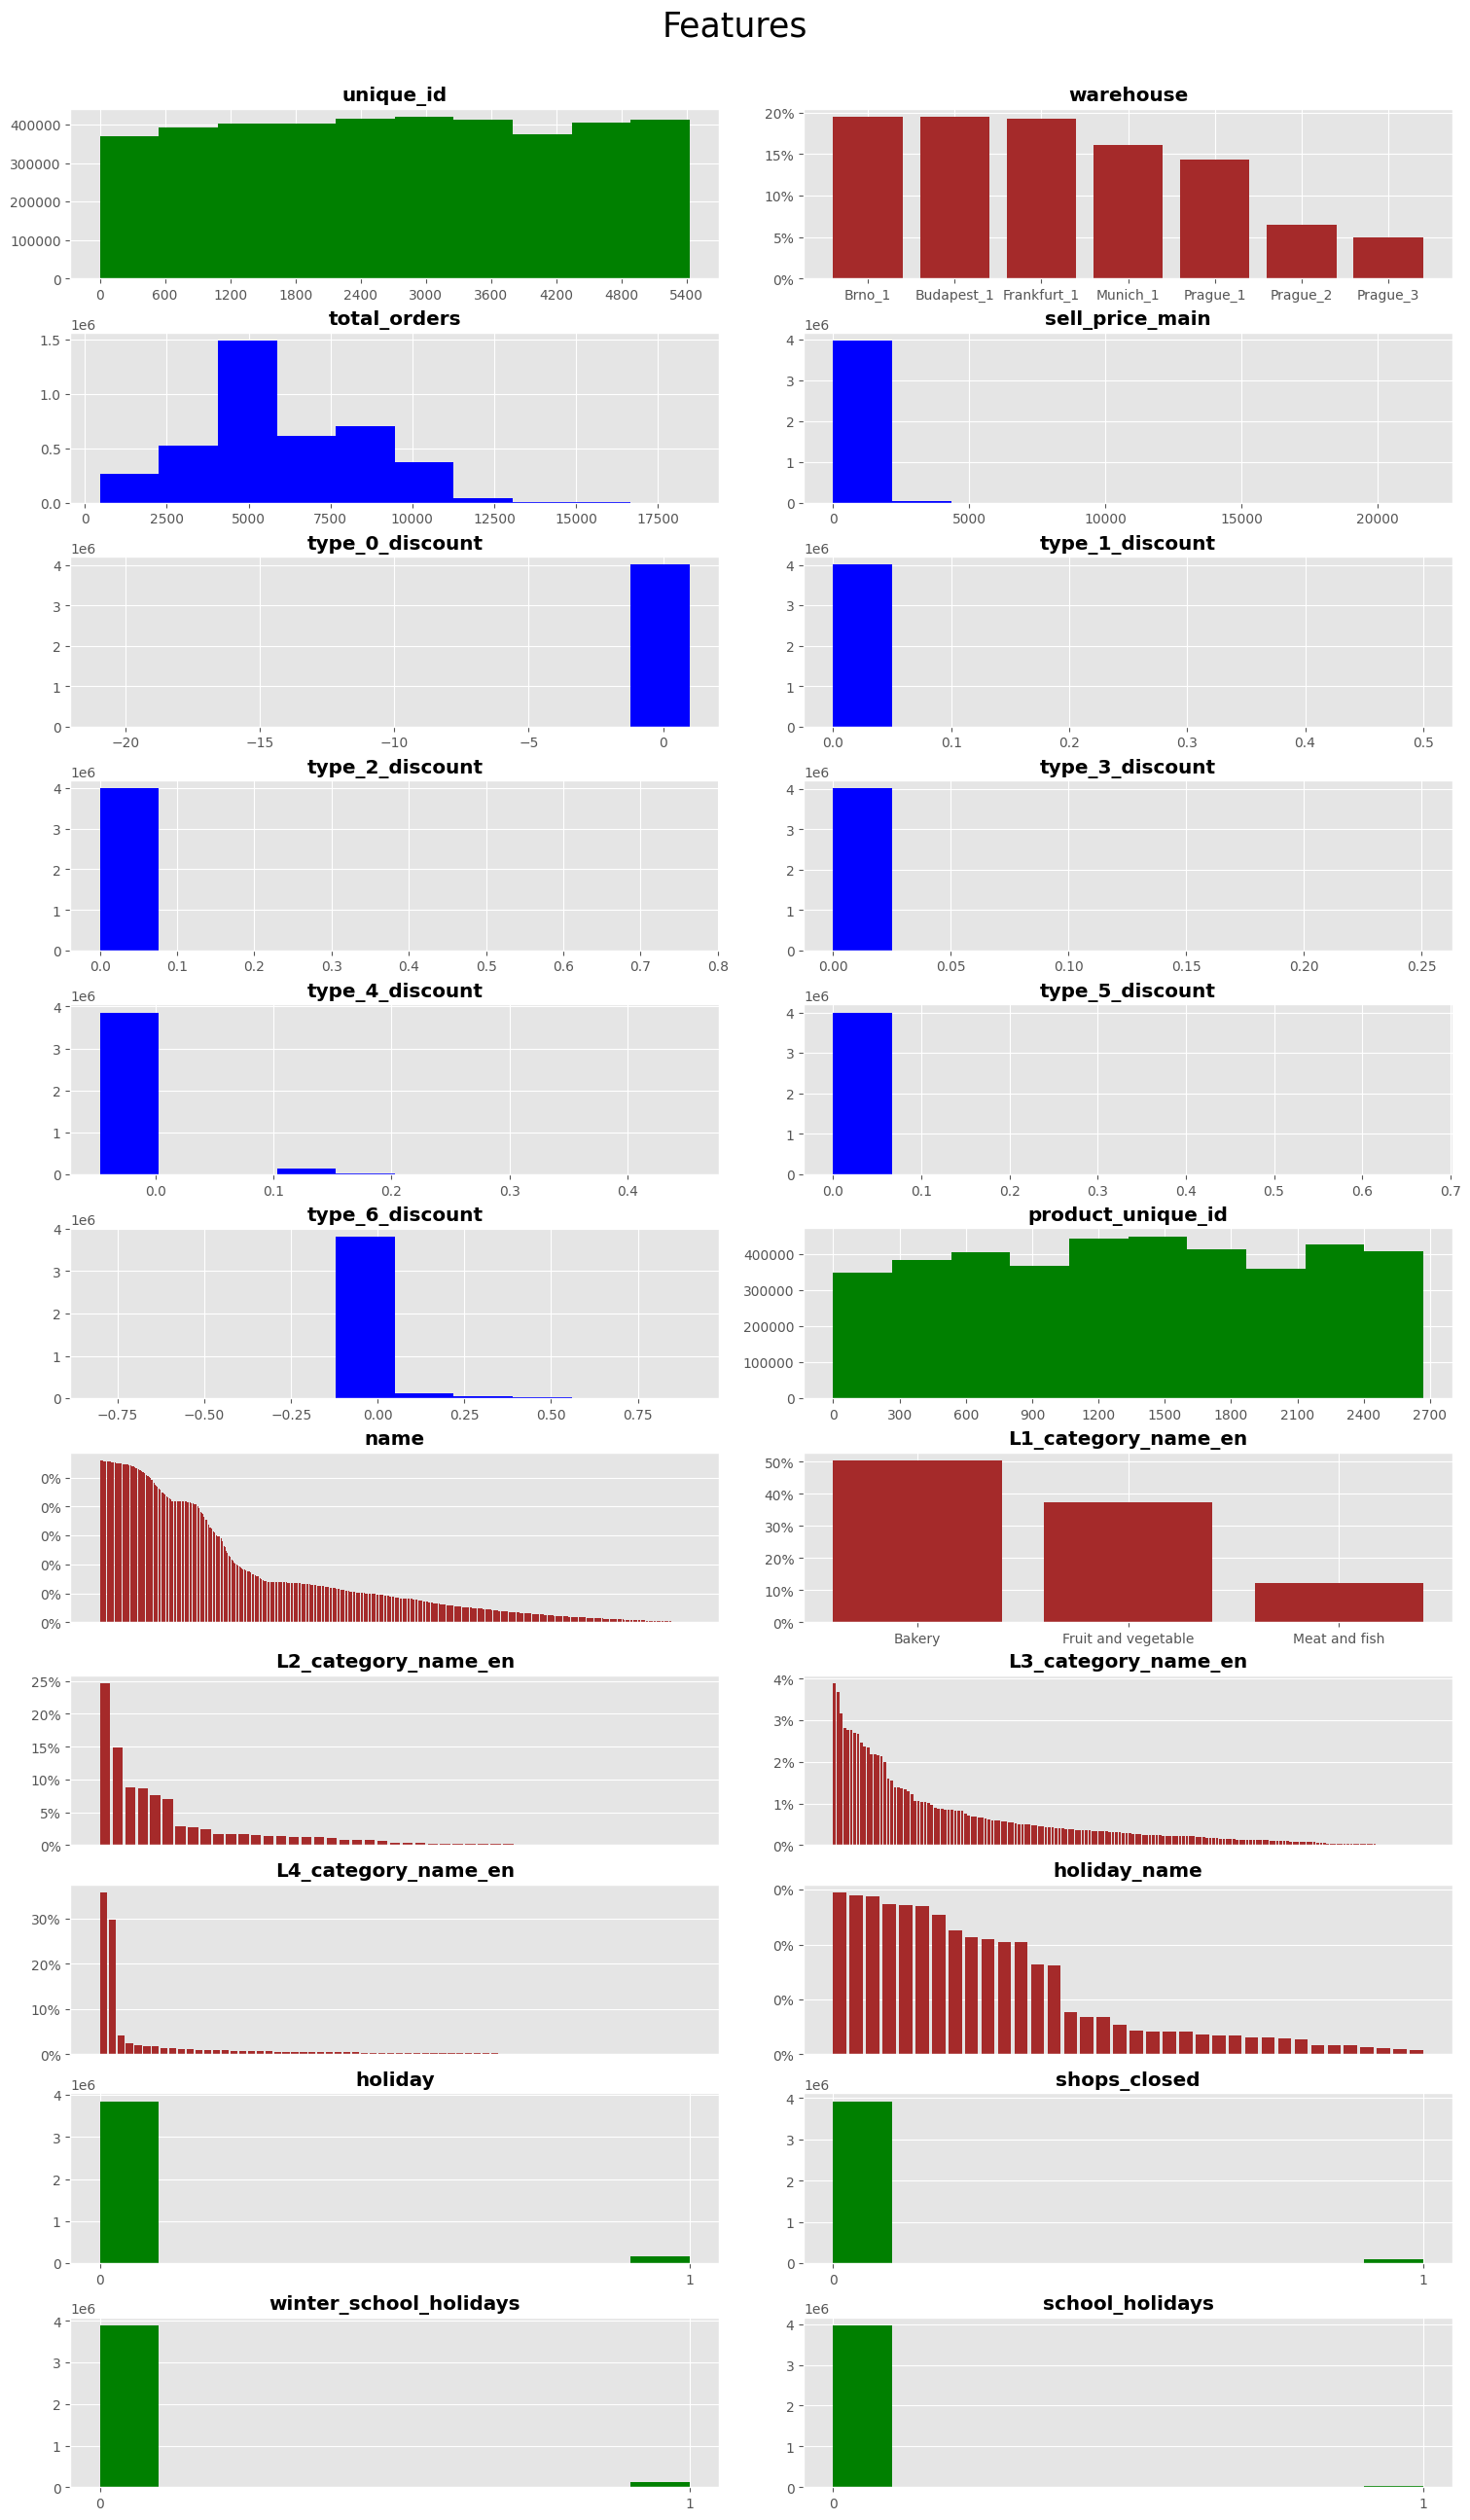

In [33]:
%%time
fig,axs= plt.subplots(11,2, figsize=(15,25),  constrained_layout=True)
for c, ax in zip(initial_features,axs.ravel()):
    if sales_train[c].dtype=='float':
        ax.hist(sales_train[c],color='blue')        
    elif sales_train[c].dtype=='category':
        vc = sales_train[c].value_counts() / len(sales_train)
        ax.bar(vc.index,vc, color='brown')
        ax.yaxis.set_major_formatter('{x:.0%}')
        if len(vc)<=15:
            ax.set_xticks(np.arange(len(sales_train[c].dtype.categories)), sales_train[c].dtype.categories)
            ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
        else:
            ax.set_xticks([])
    elif sales_train[c].dtype=='int64':        
        ax.hist(sales_train[c],color='green')        
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.set_title(f'{c}', fontweight='bold')
#axs.flat[-1].set_visible(False)
plt.suptitle('Features', y=1.03, fontsize=25);


* we have high cardinality categorical variables.
* We have many products.
* stores stay open for the most part.
* We have low prices, but there are high prices, but most focus on lower prices.
* Most products are concentrated in the Bakery category


As they are different warehouses, it is recommended that we analyze them separately, which is what we will do next.

## Checking sales by warehouse

* Most warehouse sales are of low values, but we have outputs with high values, and each warehouse has different values. prague_2 has an output of 12000, while Munich_01 has an output of 3000.

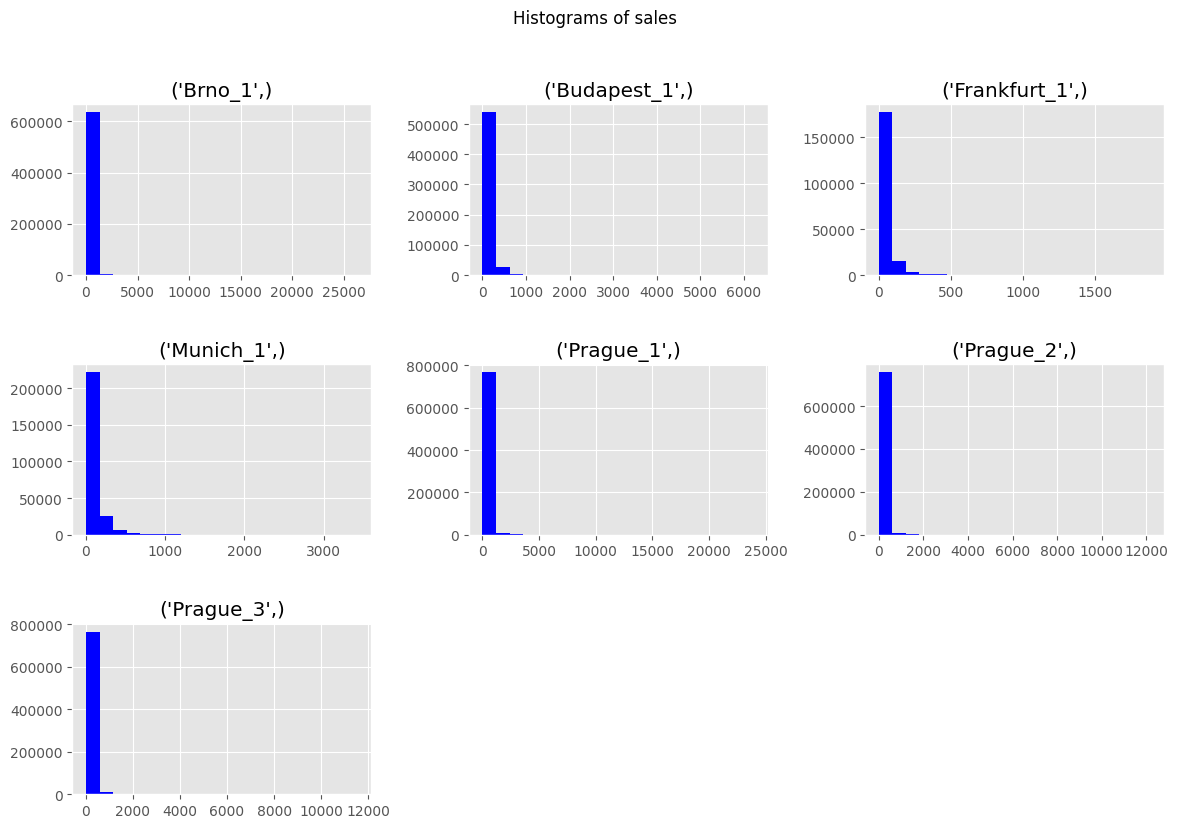

In [34]:
plt.figure(figsize=(12, 8))
for i, (combi, df) in enumerate(sales_train.groupby(['warehouse'],observed=False)):
    ax = plt.subplot(3, 3, i+1)
    ax.hist(df.sales, bins=20, color='blue')        
    #ax.set_xscale('log')    
    ax.set_title(combi)
plt.suptitle('Histograms of sales', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

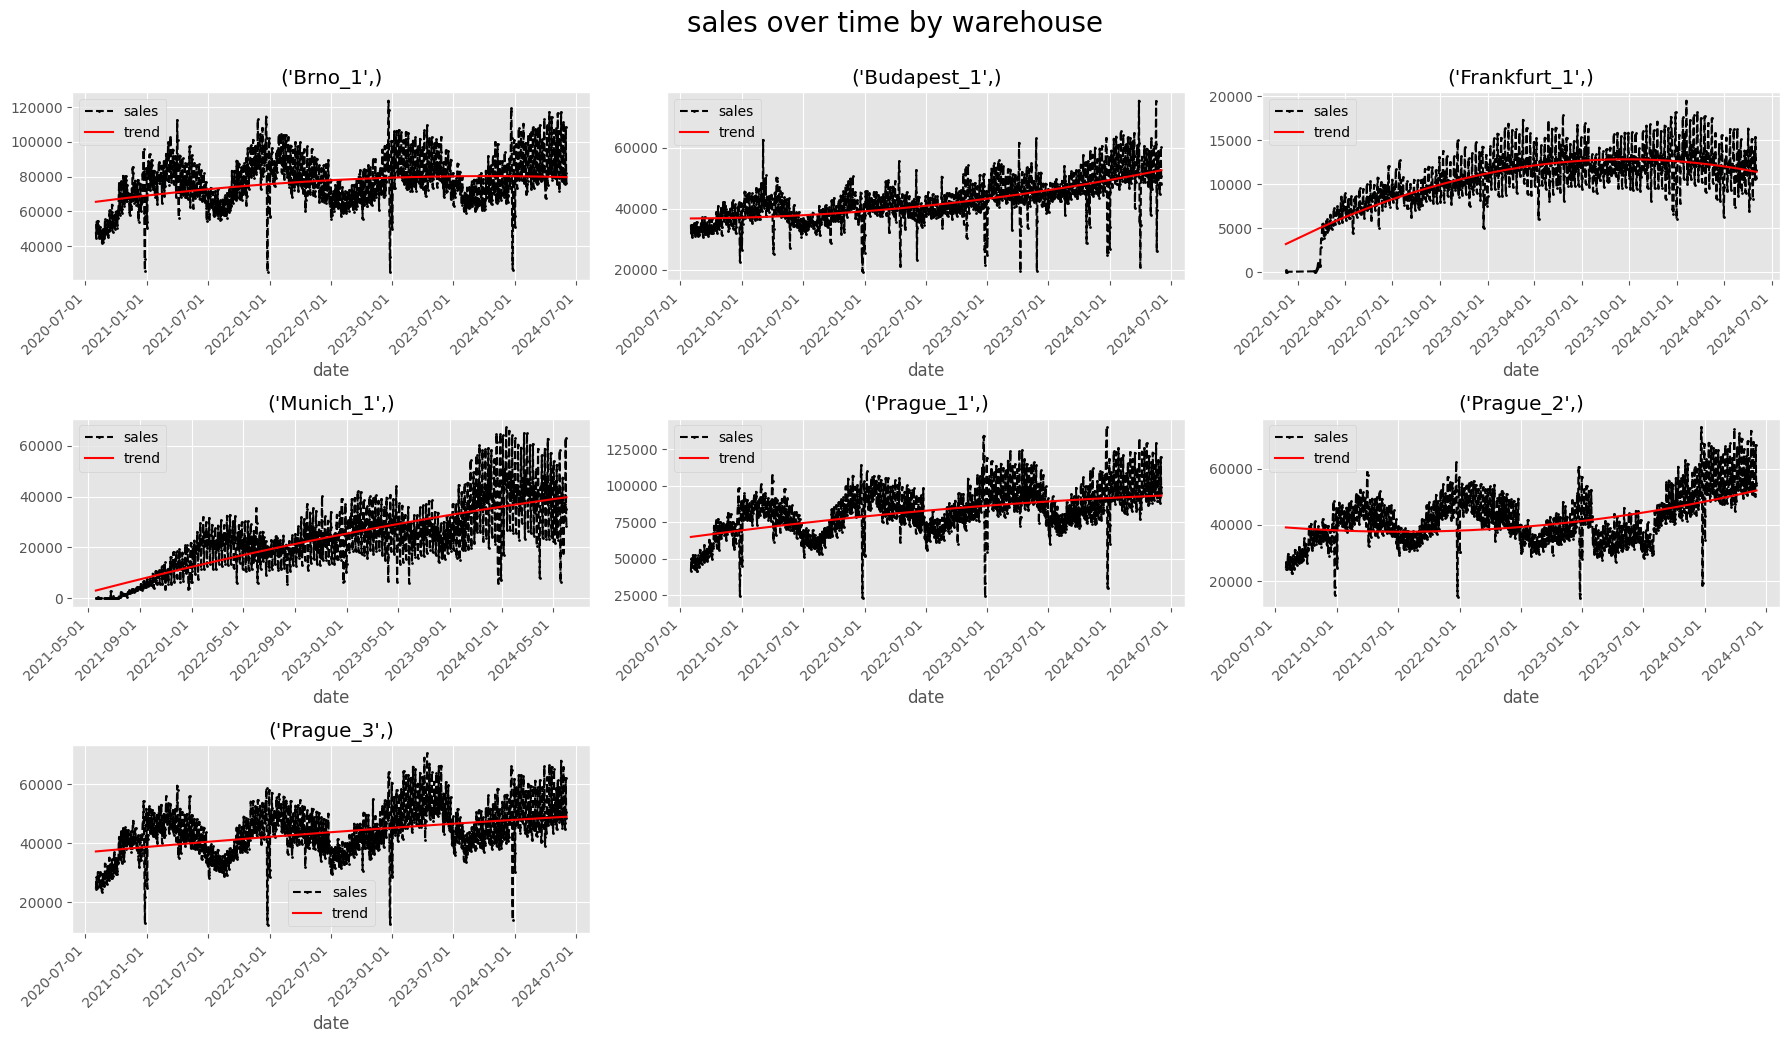

In [35]:
plt.figure(figsize=(18,22))
for i, (comb, df) in enumerate(sales_train.groupby(['warehouse'],observed=False)):
    ax = plt.subplot(7,3, i+1)        
    sales = df.sort_values(by='date').groupby('date')['sales'].sum().reset_index()
    trend = (sales.date - sales.iloc[0].date) // dt.timedelta(days=1)
    trend = trend.values.reshape(-1,1)
    model = make_pipeline(PolynomialFeatures(degree=2),
                          LinearRegression())
    model.fit(trend,sales.sales)
    y_pred = pd.Series(model.predict(trend), index=sales.date)
    
    ax.plot(sales.date,sales.sales,label='sales', color='black',marker='o',ls='--',markersize=1)
    y_pred.plot(ax=ax,color='red',label='trend')
    ax.set_title(comb)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)    
    ax.legend()   
    
    
plt.tight_layout()
plt.suptitle('sales over time by warehouse',fontsize=20,y=1.02)
plt.show()
    

* We can observe through the trend found with Linear Regression, that not all trends are always increasing.

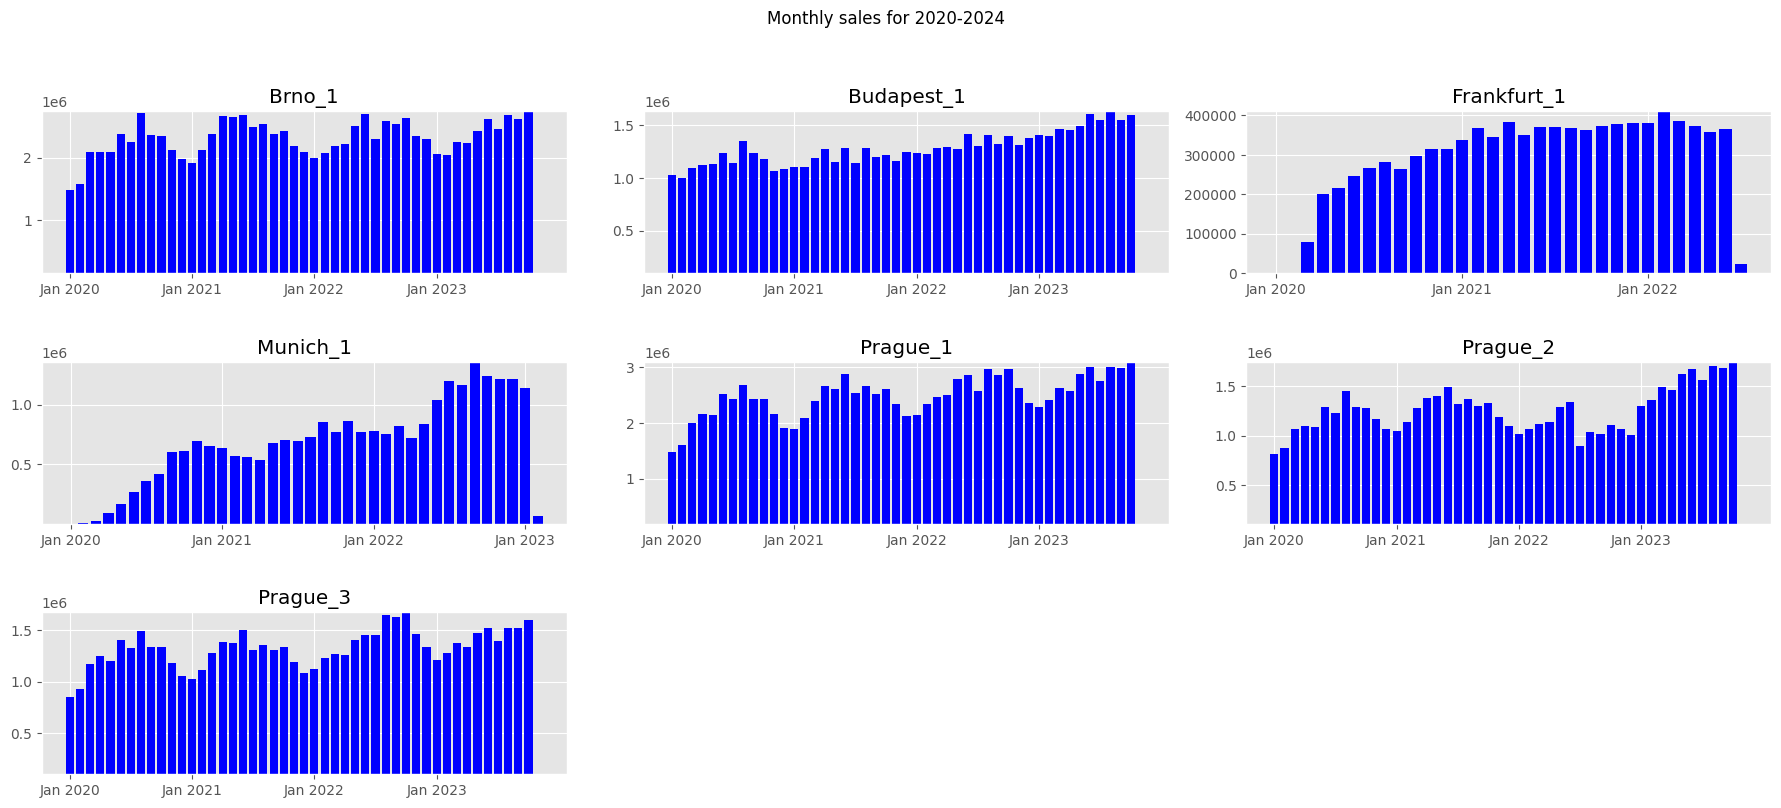

In [36]:
plt.figure(figsize=(18,10))
for i, (comb, df) in enumerate(sales_train.groupby(sales_train.warehouse,observed=False)):    
    ax = plt.subplot(4, 3, i+1, ymargin=0.5)
    
    resampled = df.resample('MS').sales.sum()
    colors = ['blue'] * len(resampled)
    ax.set_title(comb)
    ax.set_ylim(resampled.min(), resampled.max())
    ax.bar(range(len(resampled)), resampled)
    ax.set_xticks(range(0, 48, 12), [f"Jan {y}" for y in range(2020, 2024)])        
    ax.bar(range(len(resampled)), resampled, color=colors)
    
plt.suptitle('Monthly sales for 2020-2024', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()    


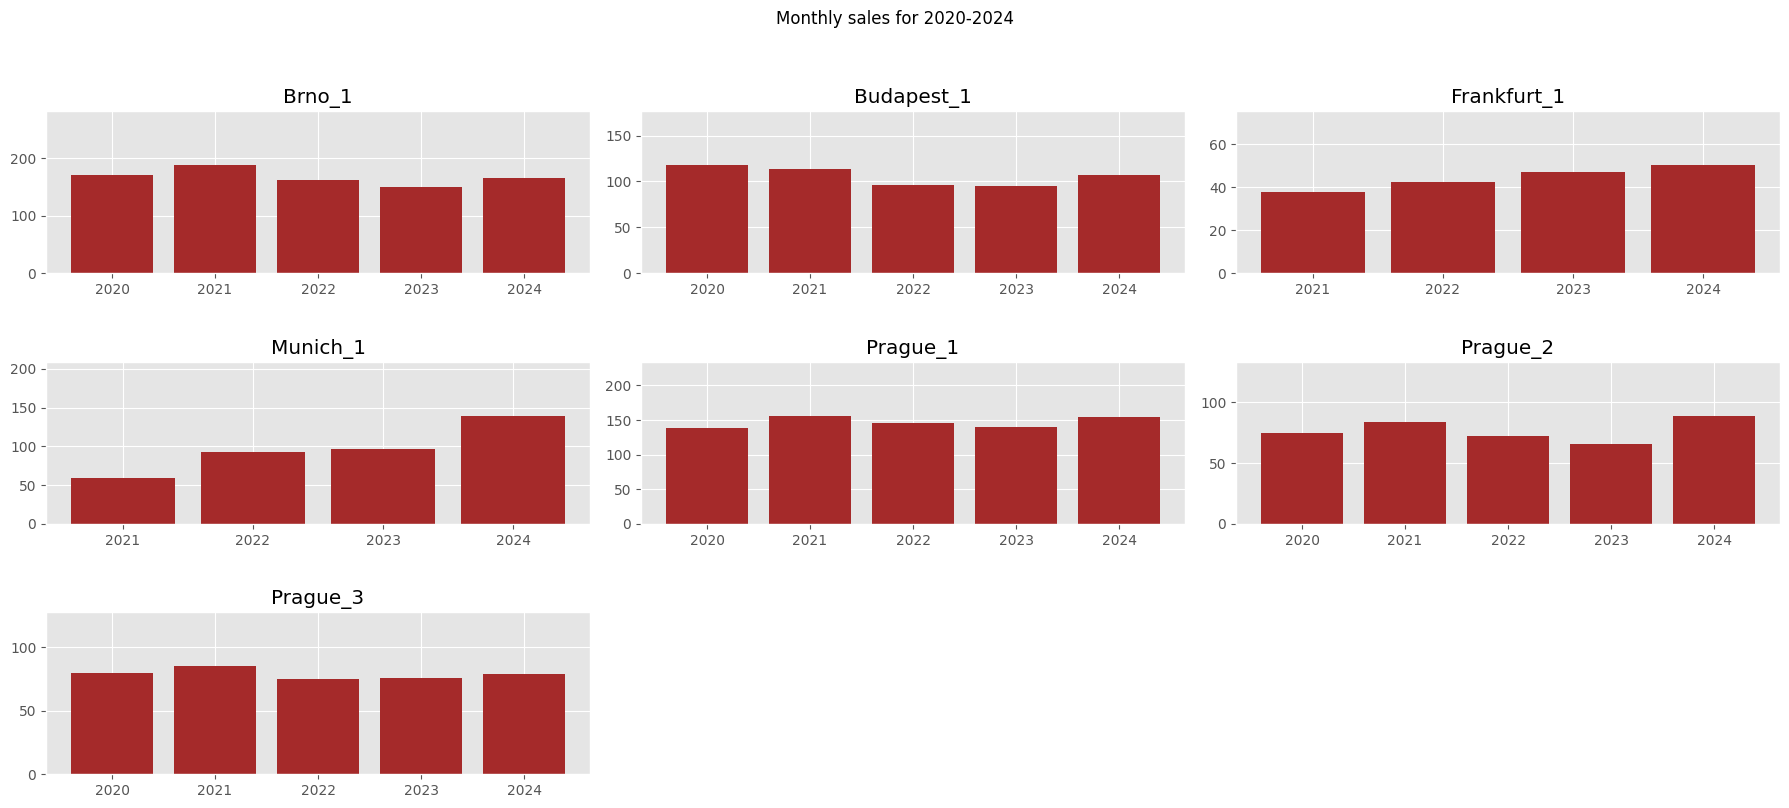

In [37]:
plt.figure(figsize=(18,10))
for i, (comb, df) in enumerate(sales_train.groupby(sales_train.warehouse,observed=False)):    
    ax = plt.subplot(4, 3, i+1, ymargin=0.5)
    
    resampled = df.resample('YS')[['sales']].mean().reset_index()
    ax.bar(resampled.date.dt.year, resampled.sales, color='brown')
    ax.set_title(comb)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
    #ax.set_ylim(0, resampled.sales.max())   

    
plt.suptitle('Monthly sales for 2020-2024', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()    


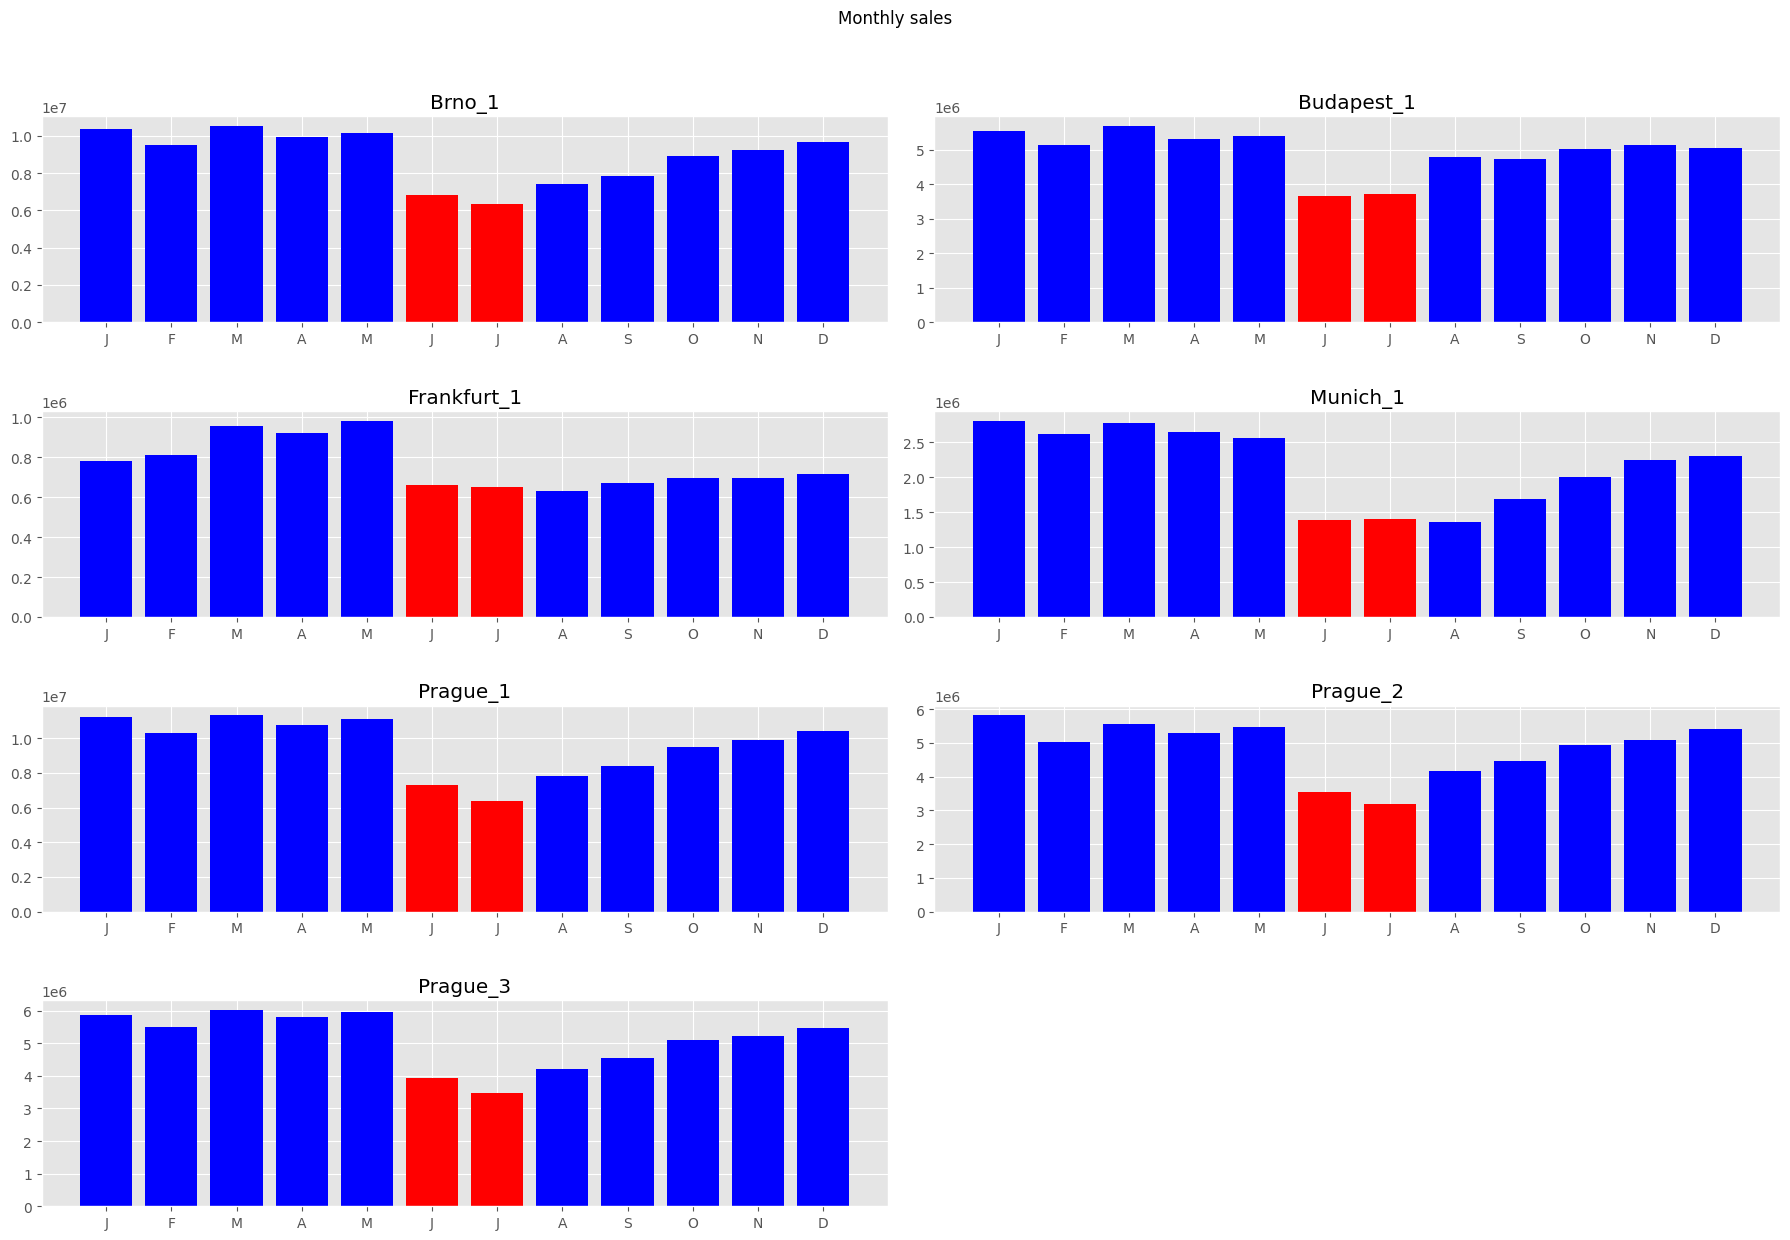

In [38]:
plt.figure(figsize=(18,12))
for i, (comb, df) in enumerate(sales_train.groupby('warehouse',observed=False)):
    ax = plt.subplot(4,2, i+1)
    resampled = df.sort_values(by='date').groupby(df.index.month)['sales'].sum()
    colors = ['b'] * 5 + ['r'] * 2 + ['b'] * 5
    ax.bar(range(1, 13), resampled, color= colors)
    ax.set_xticks(ticks=range(1, 13), labels='JFMAMJJASOND')
    ax.set_title(comb)
    #ax.set_ylim(resampled.min(), resampled.max())
        
    
plt.suptitle('Monthly sales', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()
    

* as a whole, the months of June and July are the ones that sell the least

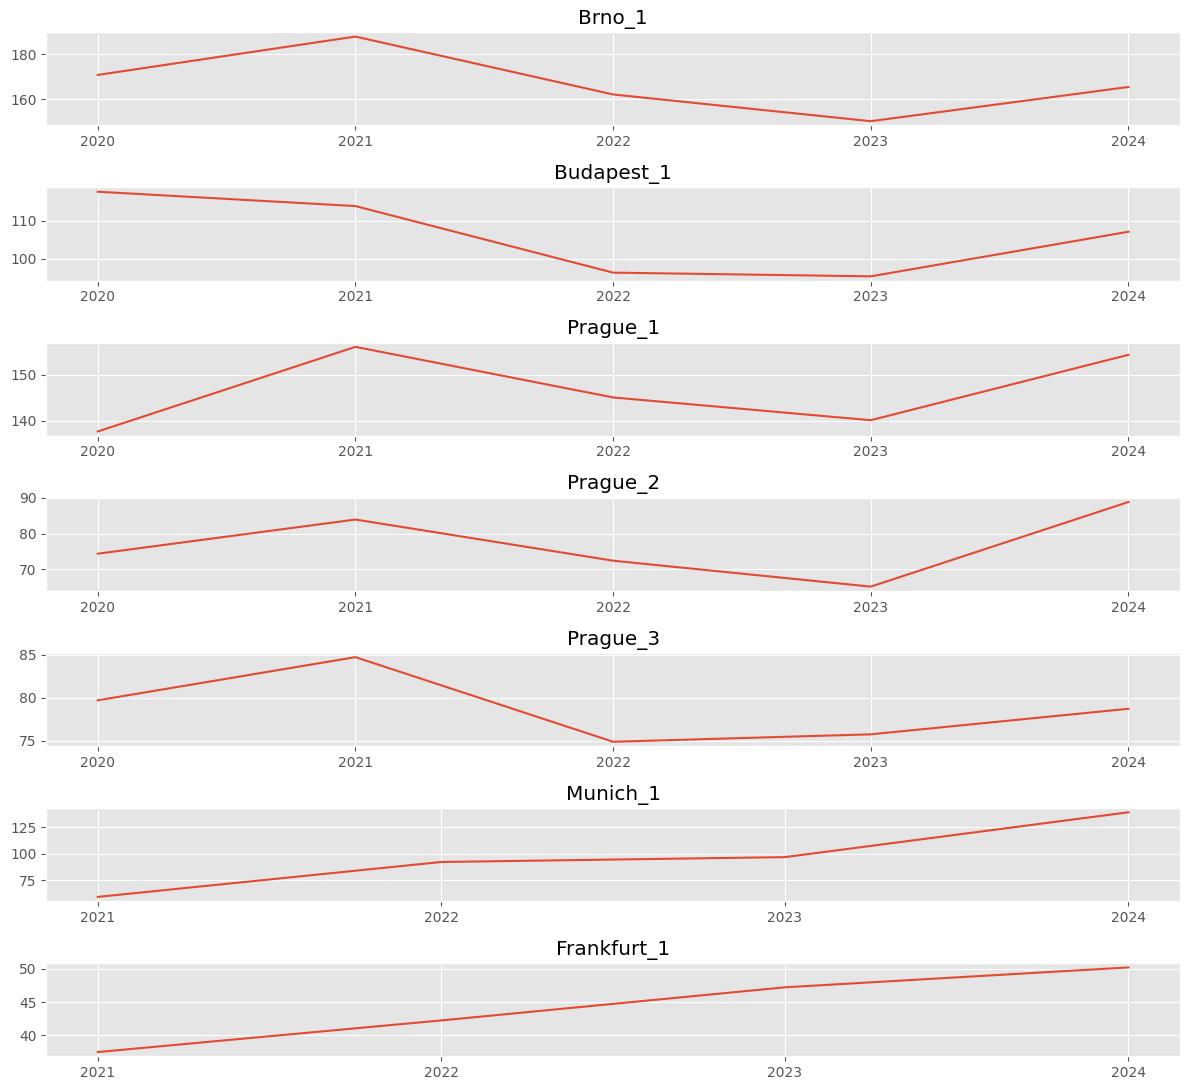

CPU times: user 1.58 s, sys: 202 ms, total: 1.78 s
Wall time: 1.46 s


In [39]:
%%time
yearp = sales_train.groupby(['warehouse',sales_train.index.year],observed=True)['sales'].mean().reset_index()
plt.figure(figsize=(12,11))
for i,w in enumerate(u_warehouses):
    ax = plt.subplot(len(u_warehouses),1,i+1)
    ax.plot(yearp[yearp.warehouse==w]['date'],yearp[yearp.warehouse==w]['sales'])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(w)
plt.tight_layout()
plt.show()

* Only munich_1 and Frankurt_1 had an increasing increase in sales per year.

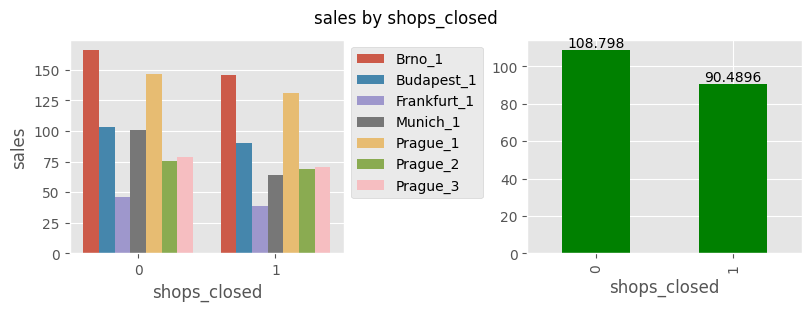

In [40]:
mean_sales = sales_train.groupby(['shops_closed','warehouse'],observed=False)['sales'].mean().reset_index().sort_values(by='sales')
#pivot_data = mean_sales.pivot(index='shops_closed', columns='warehouse', values='sales').fillna(0)
#pivot_data.plot(kind='bar',stacked=True)
_, axs = plt.subplots(1,2,figsize=(8,3), constrained_layout=True)
ax = axs.ravel()
sns.barplot(data=mean_sales, x='shops_closed', y='sales', hue='warehouse', errorbar=None, ax=ax[0])
ax[0].legend(bbox_to_anchor=[1,1])
sales_train.groupby(['shops_closed'])['sales'].mean().plot(kind='bar',ax=ax[1],color='green')
ax[1].bar_label(ax[1].containers[0])
plt.suptitle('sales by shops_closed');

* the percentage increase in relation to mean sales with a closed store is 20.25% (108798 - 904896 / 904896).
* all warehouses sell more with stores open than closed.

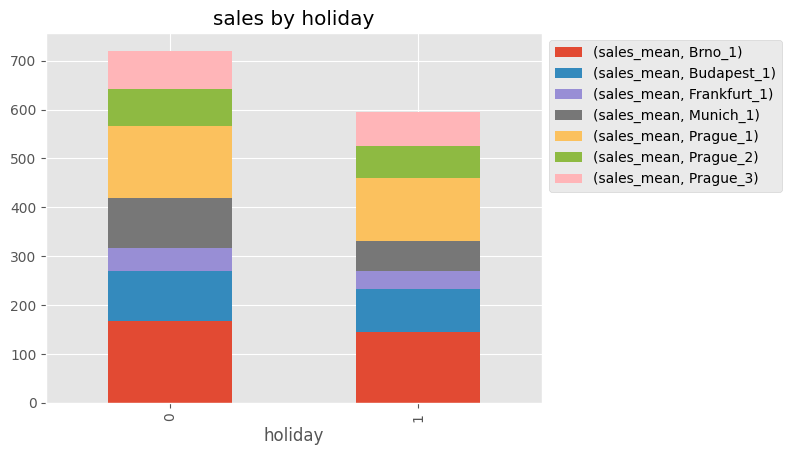

In [41]:
tmp =sales_train.groupby(['warehouse','holiday'], observed=False).agg(
    sales_mean = ('sales','mean'),
    sales_min  = ('sales','min'),
    sales_max  = ('sales','max')
)
ax = tmp.unstack(level='warehouse')[['sales_mean']].plot(kind='bar', stacked=True)
ax.legend(bbox_to_anchor=[1,1]);
plt.title('sales by holiday');

In [42]:
from IPython.display import display

In [43]:
crosstab1 = pd.crosstab(index=sales_train['shops_closed'], 
                         columns=sales_train['holiday'], 
                         margins=False)

styled_crosstab1 = crosstab1.style.background_gradient(axis=0, cmap='YlOrRd')
styled_crosstab2 = pd.crosstab(index=[sales_train['shops_closed'], sales_train['warehouse']], 
                        columns=sales_train['holiday'], 
                        margins=False).style.background_gradient(axis=0, cmap='coolwarm')

display(styled_crosstab1)



display(styled_crosstab2)

holiday,0,1
shops_closed,,
0,3843953,72231
1,0,91235


* 3,843,953 sales when stores are open and it is not a holiday. This indicates a very high sales volume.
72,231 sales when stores are open on public holidays. This number is significantly lower, suggesting that sales decrease around holidays.
0 sales when stores are closed and it is not a holiday. This is to be expected as there are no sales if stores are closed.
91,235 sales when stores are closed during holidays. This may suggest that even with stores closed, there is some type of sale or transaction (such as online sales).

* For days when stores are closed (1), most sales are 0 in warehouses, except for a few, where there are still sales recorded, indicating that some stores may be operating differently or using a delivery model.

# Fixing NaN values

In [44]:
sales_train.loc[sales_train.sales.isnull(),:].reset_index().groupby(['warehouse'],observed=False). \
agg(size=('warehouse','size'),
    min_date=('date','min'),
    max_date=('date','max'),
    days = ('date', lambda x: x.max() - x.min()),
    split_date=('date', lambda x: list(np.unique(np.unique(x.dt.strftime('%Y-%m-%d'))))) 
   ).dropna()

,size,min_date,max_date,days,split_date
warehouse,,,,,
Frankfurt_1,6,2021-12-09,2021-12-10,1 days,"[2021-12-09, 2021-12-10]"
Munich_1,46,2021-05-21,2021-07-11,51 days,"[2021-05-21, 2021-05-22, 2021-05-23, 2021-05-2..."


* We have sales and price records without information, this may be due to an error in data collection.

In [45]:
sales_train['sales'] = sales_train['sales'].fillna(0)
sales_train['total_orders'] = sales_train['total_orders'].fillna(0)
sales_train['sell_price_main'] = sales_train['sell_price_main'].interpolate()

# Periodogram

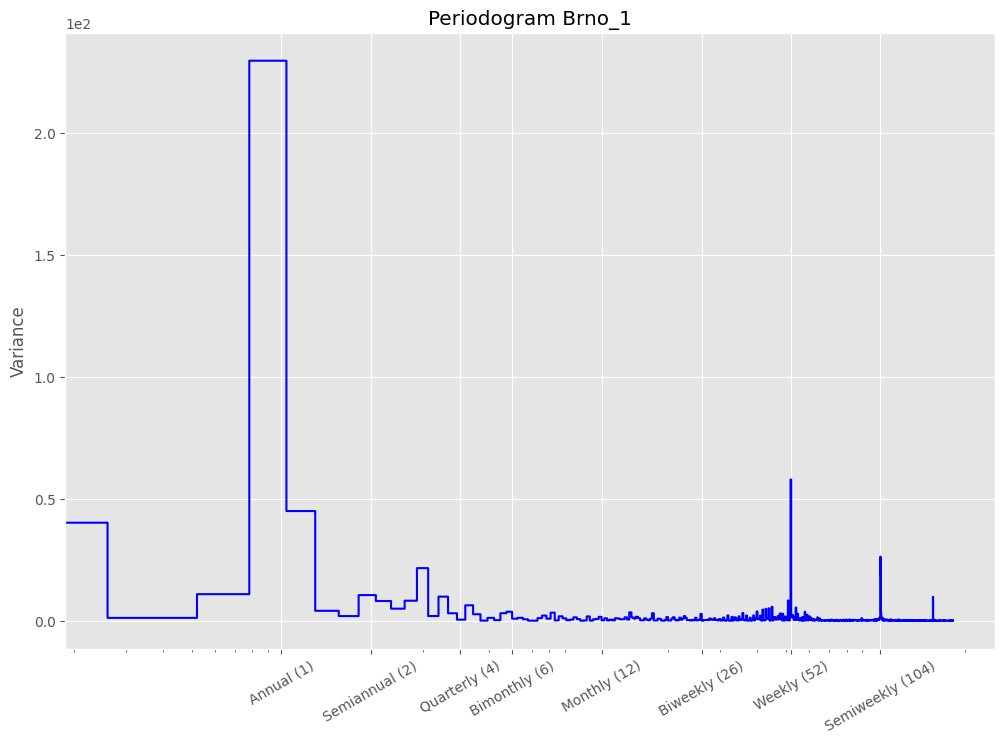

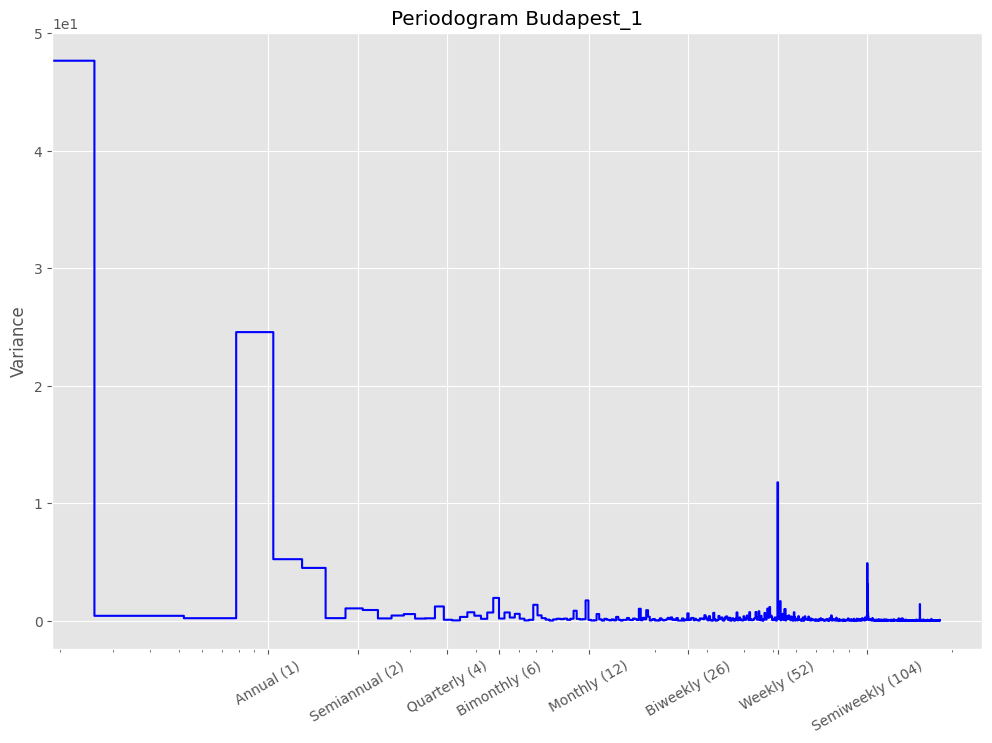

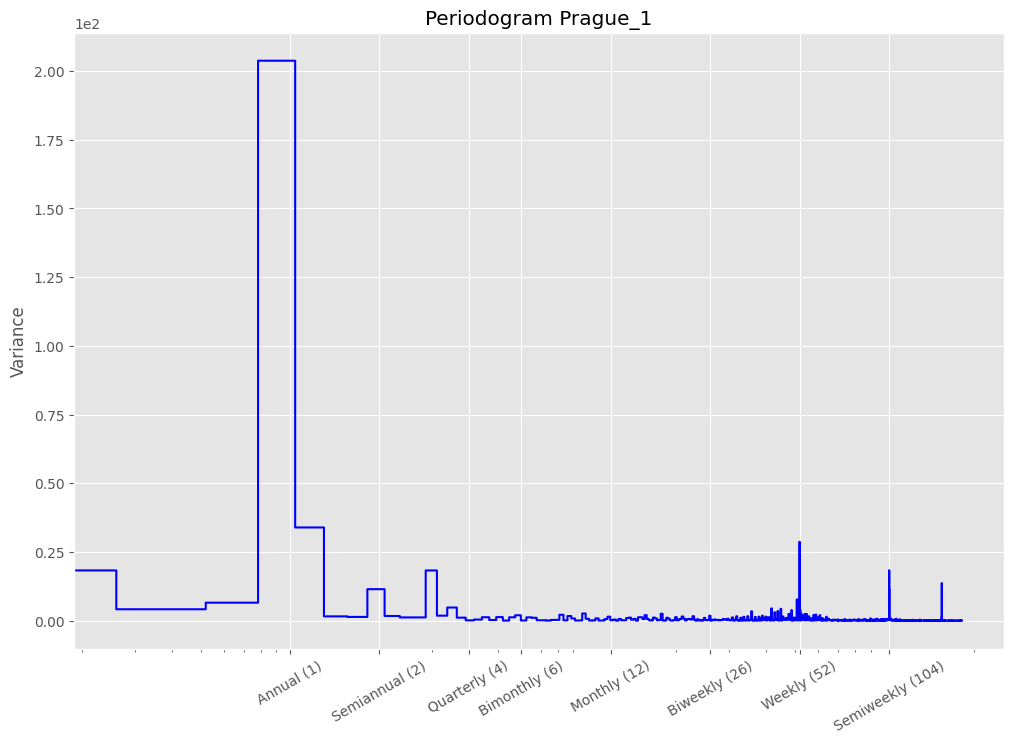

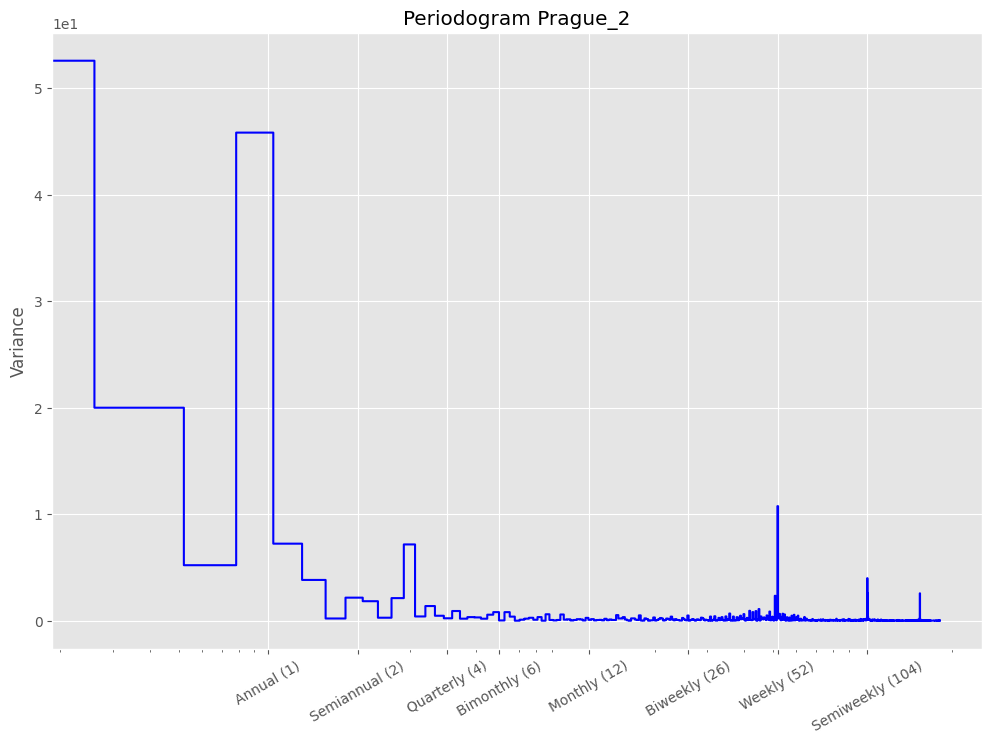

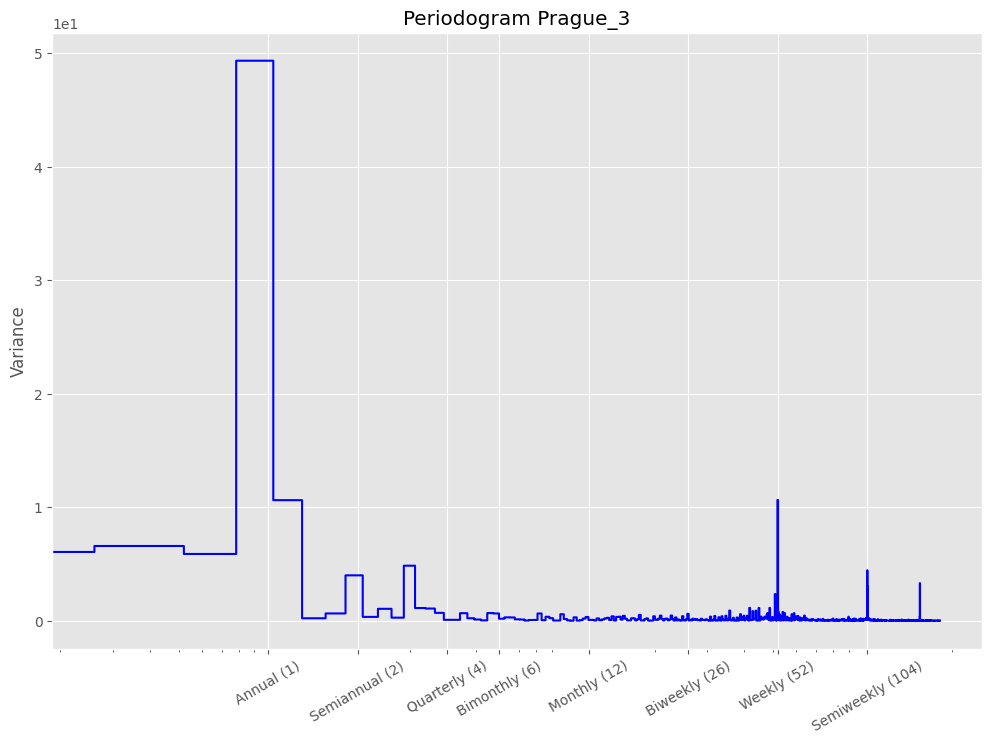

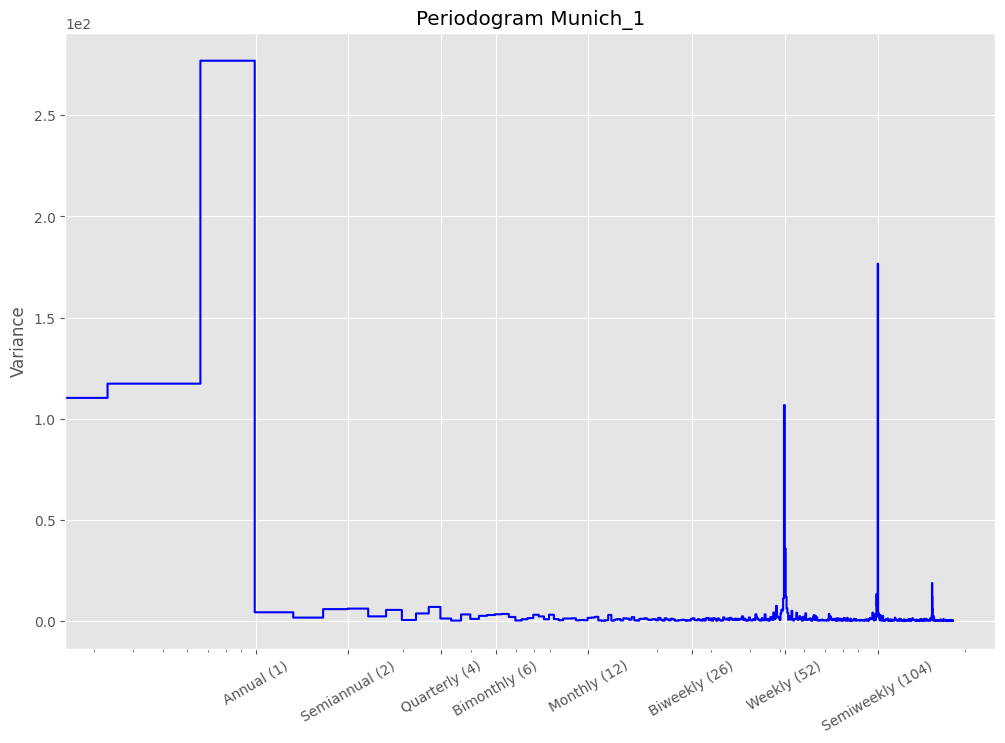

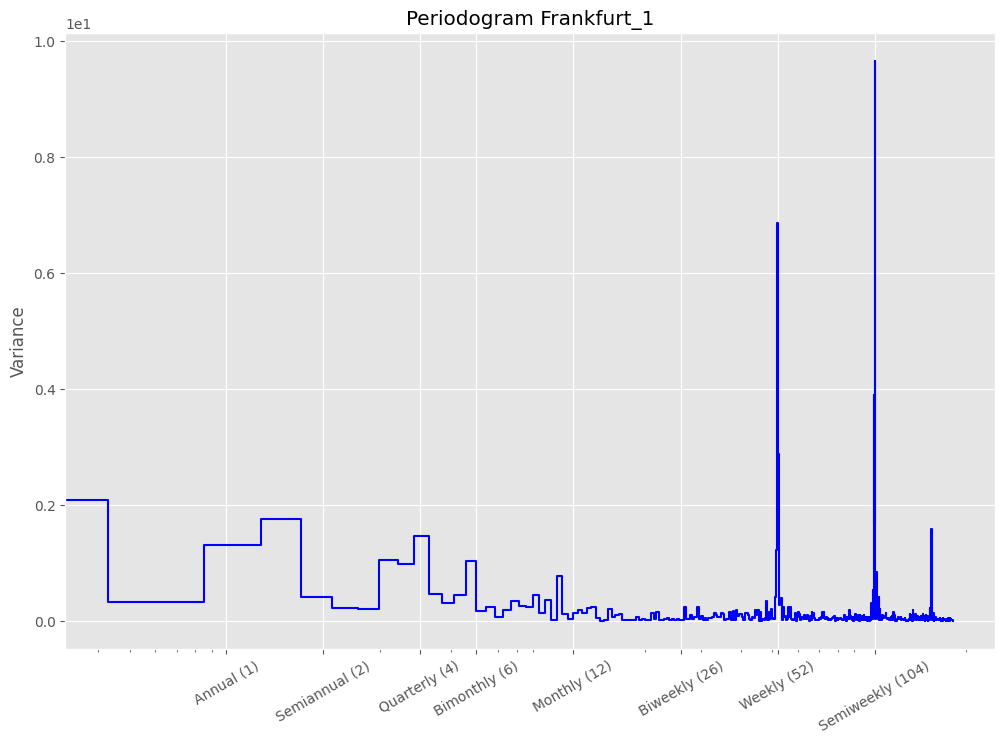

In [46]:
def plot_periodogram(serie,wh,ax=None):     
    fs = pd.Timedelta('365D') / pd.Timedelta('1D')
    freq, spec = periodogram(serie, fs=fs,detrend='linear',scaling='spectrum')
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))  
    ax.step(freq, spec, color="blue")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title(f"Periodogram {wh}")

for u in u_warehouses:
    plot_periodogram(sales_train[sales_train.warehouse==u].groupby('date').sales.mean(),u)

* Through the periodogram we can see that most warehouses have an annual seasonality and some have weekly and semi-weekly seasonality. This helps us create features so that the models can capture the seasonality of the series.

In [ ]:
#fig = calplot.calplot(sales_train.query('holiday==1').sales, how = "sum", cmap='jet')

# Metric

* The wMAE (Weighted Mean Absolute Error) metric is a variation of the mean absolute error that considers weights for each observation. This allows some variations to have more influence on the total error calculation, which is useful in situations where some samples are more relevant than others.

In [ ]:
weight_map = test_weights.set_index('unique_id')['weight'].to_dict()

In [ ]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
class DropColsTransformer(BaseEstimator, TransformerMixin):

    def __init__(self,cols):
        self.cols = cols
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return X.drop(self.cols,axis=1)

In [ ]:

class CreateTimeFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()                
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['weekday'] = df.index.weekday
        df['week'] = df.index.isocalendar().week
        df['weekend'] = df.index.weekday // 5
        df['semiweekly'] = np.where(df.index.weekday <3,0,1)    
        df['year_sin'] = np.sin(df['year'] / 1 * 2 * np.pi)
        df['year_cos'] = np.cos(df['year'] / 1 * 2 * np.pi)
        df['month_sin'] = np.sin(df['month'] / 12 * 2 * np.pi)
        df['month_cos'] = np.cos(df['month'] / 12 * 2 * np.pi)
        

        return df
    

# Feature Engineering


In [ ]:
ctf = CreateTimeFeatures()
sales_train = ctf.fit_transform(sales_train).copy()  
sales_test = ctf.fit_transform(sales_test).copy() 

my_index = sales_train.index
my_index_ts = sales_test.index

agg_df = sales_train.reset_index().groupby(['name'],observed=False).agg(days_in_sale=('date','nunique'),
                                                                   purchase_interval=('date',lambda x: (x.max() - x.min()).days)                                                               
                                                                  ).reset_index()
sales_train = sales_train.merge(agg_df[['name', 'days_in_sale', 'purchase_interval']], on='name', how='left')
sales_test = sales_test.merge(agg_df[['name', 'days_in_sale', 'purchase_interval']], on='name', how='left')
sales_train.set_index(my_index,inplace=True)
  
sales_train.loc[:,'date_diff'] = sales_train.reset_index().groupby('name',observed=False)['date'].diff().dt.days.fillna(0).reset_index()['date'].values
sales_train['gap'] = sales_train['date_diff'] > 1
sales_train['gap_group'] = sales_train.groupby(['name'],observed=False)['gap'].cumsum()
agg_df = sales_train.groupby(['name', 'gap_group'],observed=False)['date_diff'].max().reset_index()
agg_df = agg_df.groupby('name',observed=False)['date_diff'].max().rename('days_without_sale')
sales_train = sales_train.merge(agg_df, on='name', how='left')
sales_test = sales_test.merge(agg_df, on='name', how='left')

sales_train.set_index(my_index,inplace=True)
sales_test.set_index(my_index_ts,inplace=True)

# Cross Validate

In [ ]:
oofs = {}
scores = {}
test_preds = {}
COMPUTE_TEST = True

In [ ]:
def cross_validate(estimator, features, plot_residuals=False, fit_params={}):
    kf = TimeSeriesSplit(n_splits=5,test_size=dt.timedelta(weeks=2).days)
    X = sales_train[features].copy()
    y = sales_train[target]
       
    model = clone(estimator)
    val_preds = np.zeros(len(X))
    list_scores = []
    
    for fold, (trx_idx, val_idx) in enumerate(kf.split(X,y,groups=X['warehouse'])):        
        X_train, y_train = X.iloc[trx_idx], y.iloc[trx_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]      
                
        model.fit(X_train.drop('unique_id',axis=1),y_train, **fit_params)
        y_pred = model.predict(X_val.drop('unique_id',axis=1)).clip(0,None)
        val_preds[val_idx] += y_pred
        wmape = mean_absolute_error(y_val,y_pred,sample_weight=X_val["unique_id"].map(weight_map).values)
        list_scores.append(wmape)
        
        print(f' #{fold} - wmae: {wmape}')
        if plot_residuals:
            display = PredictionErrorDisplay.from_predictions(y_val,y_pred)            
            plt.show()
    if isinstance(model,Pipeline):
        name_model = type(model[-1]).__name__
    else:
        name_model = type(model).__name__                              
    

    oofs[name_model] = val_preds
    scores[name_model] = list_scores
    print(f'wmae mean: {np.mean(list_scores)}')   
    
    if COMPUTE_TEST:
        print('Computing Test prediction....')
        model = clone(estimator)
        model.fit(X,y)
        
        test_pred = model.predict(sales_test[features]).clip(0,None)
        test_preds[name_model] = test_pred
        print('Computing Test prediction - Ok')

## Modeling

* In this first stage, the Ridge, LightGBM and XGBoost models will be used, all of which will be used with their default parameters.


## Ridge

In [ ]:
cross_validate(make_pipeline(             
             TargetEncoder(cols=['name',
                                 'holiday_name',
                                 'L2_category_name_en',
                                 'L3_category_name_en',
                                 'L4_category_name_en']),                                                    
             OneHotEncoder(cols=['warehouse','L1_category_name_en']),      
             StandardScaler(),                          
             Ridge()),initial_features+['days_in_sale', 'purchase_interval','days_without_sale',
                                        'year_sin','year_cos','month_sin','month_cos'])

 ## LGBM

In [ ]:
cross_validate(make_pipeline(             
             TargetEncoder(cols=['name',
                                 'holiday_name',
                                 'L2_category_name_en',
                                 'L3_category_name_en',
                                 'L4_category_name_en']),                                     
             LGBMRegressor(verbosity=-1)),initial_features+['days_in_sale', 'purchase_interval','days_without_sale',
                                                           'year_sin','year_cos','week','weekday'])

# XGBoost

In [ ]:
cross_validate(make_pipeline(             
             TargetEncoder(cols=['name',
                                 'holiday_name',
                                 'L2_category_name_en',
                                 'L3_category_name_en',
                                 'L4_category_name_en']),                                     
             XGBRegressor(verbosity=0,enable_categorical=True)),
             initial_features+['days_in_sale', 'purchase_interval'])

# Scores

In [ ]:
df_score = pd.DataFrame().from_dict(scores)
ax = df_score.mean().sort_values(ascending=False).plot(kind='barh')
bars = ax.patches
bars[-1].set_color('green')
ax.bar_label(ax.containers[0],label_type='center',color='white',fontweight='bold')
plt.title('scores')
ax.set_xlabel('wmae')
plt.show()

* LGBM took this among the three models.

# Submission

In [ ]:
if COMPUTE_TEST:
    solution['sales_hat'] = test_preds['LGBMRegressor'].clip(0,None)
    solution.to_csv('submission.csv',index=False)


This notebook was a baseline, it is possible to greatly improve the result.
To improve we can:
 * Tune model hyperparameters
 * Ensemble models
 * Doing a deeper analysis to capture seasonality for models like Ridge makes a difference.
 * Testing other models, such as CatBoost.

# what did I learn? 

- pandas funziona anche con indici duplicati -> conviene usare la data come indice nell'analisi di time series
- ci sono funzioni per fare tutto ma non ti viene in mente di usarle o di chiedere a chatgpt se non le hai mai usate
- struttura da seguire per progetto di ML: 1) pensa alla forma in cui mettere i dati di input per avere operazioni piu' comode e intuitive dopo 2) controlla tutto cio' che manca o che non è ideale nel dataset (missing, categorie presenti nel test ma non nel training, ..)
- converting object variables to categorical saves space (cause categorical encode only the unique values. Eg in this problem i can save 200MB of space for a single column ..)
- preprocessing strategies: grouping and computing aggregate statistics
- we can use fourier analysis to get information abaout the periodicity of the sales (or other quantities)